In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import xml.etree.ElementTree as ET
import pickle as cPickle
import argparse

import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
import torchvision.transforms as T

import torch.nn as nn
import torch

# !pip install albumentations==1.1.0
!pip install git+https://github.com/albumentations-team/albumentations.git
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import sys
sys.path.insert(0,"/content/drive/MyDrive/Github/BirdDetection-FeaturesExtraction/dataset")

  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-df42p_bm
  Running command git clone -q https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-df42p_bm
     |████████████████████████████████| 47.7 MB 1.4 MB/s 
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=112723 sha256=f596f7bd4b123012ab79c1e76379a0faf1cde5a77c7e5c83c3e45af42354ebe9
  Stored in directory: /tmp/pip-ephem-wheel-cache-y2nictzz/wheels/09/5b/e0/38cb85186b3cb979092395de69893163f9a223a72066123599
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
# !pip install "opencv-python-headless<4.3"
# !pip freeze
!python --version

Python 3.7.12


In [3]:
# Manage multiple versions of python with pip
# py -3.8 -m pip install package
#https://stackoverflow.com/questions/2812520/dealing-with-multiple-python-versions-and-pip
# Inspired by torchvision example: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

class BirdDataset(torch.utils.data.Dataset):
    """Class to charecterize the bird dataset"""

    def __init__(self, root_dir, transforms=None):
        """
        Args:
            root_dir (string): Directory with all the images
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root = root_dir
        self.transforms = transforms
        
        self.imgs = list(sorted(os.listdir(os.path.join(root_dir, "all_images")), key=lambda x: int(os.path.splitext(x)[0])))  # list of all image names - jpg
        self.boxes = list(sorted(os.listdir(os.path.join(root_dir, "all_labels")), key=lambda x: int(os.path.splitext(x)[0]))) # list of all image names - xml
    
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        """Loads and returns a sample from the dataset at the given index idx"""
        # load images and boxes
        img_path = os.path.join(self.root, "all_images", self.imgs[idx])
        box_path = os.path.join(self.root, "all_labels", self.boxes[idx])
        # print("Image path", img_path)
        # print(type(cv2.imread(img_path, cv2.IMREAD_COLOR)))
        # img = Image.open(img_path).convert("RGB")
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img /= 255.0
        
        # get boxes for each bird
        document = ET.parse(box_path)
        root = document.getroot()
        boxes = []
        for item in root.findall(".//object/bndbox"):
            xmin = float(item.find('xmin').text)
            xmax = float(item.find('xmax').text)
            ymin = float(item.find('ymin').text)
            ymax = float(item.find('ymax').text)

            box = [xmin, ymin, xmax, ymax]
            boxes.append(box)
        num_objs = len(boxes)

        # convert everything into a torch.Tensor
        image_id = torch.tensor([idx+1])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64) # only one class : a bird
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        # target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        # target["iscrowd"] = iscrowd

        if self.transforms is not None:
            # img = self.transforms(img)
            sample = {
                'image': img,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)

            img = sample['image']
            if len(sample['bboxes']) == 0: # 
                target['boxes'] = torch.zeros((0, 4), dtype=torch.float32)
            else:
                target['boxes'] = torch.tensor(sample['bboxes'])

        return img, target

In [ ]:
def get_model(trained=True, save_path=None):
  device = 'cpu'
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  num_classes = 2  # 1 class (bird) + background

  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features

  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  model.to(device)

  if trained:
    if save_path == None: print("No path tto the saved model")
    model.load_state_dict(torch.load(save_path))

  return model

# What is the difference between the YOLO version ?
# def get_YOLOv5model(trained=True, save_path=None):
#   return model

In [4]:
#########
# UTILS #
#########
def collate_fn(batch):
  """Necessary for DataLoader"""
  return tuple(zip(*batch))

def get_transform(train):
  """Tansform the training and test set. Data Augmentation is made here."""
  transforms = []
  transforms.append(A.Resize(224, 224, interpolation = cv2.INTER_LANCZOS4))
  if train:
      transforms.append(A.Flip(0.5))
      transforms.append(A.ColorJitter())
      # transforms.append(A.RandomCrop(width=576, height=576))
      # transforms.append(A.Normalize(mean=[0.598, 0.554, 0.508], std=[0.090, 0.081, 0.076]))           
  transforms.append(ToTensorV2(p=1.0)) 
  return A.Compose(transforms, bbox_params={'format': 'pascal_voc', 'min_visibility': 0.6, 'label_fields': ['labels']})

def save_performance(score, filename):
  """Save the scores (4) on a txt file of name filename"""
  return 0

class Performance():
    """Class to calculate and store the performance/score of a model"""
    def __init__(self, root_save=None, args=None):
        """
        Args:
            root_save (string): 
            params (callable, optional):
        """
        self.root_save = root_save
        self.args = args
        self.train_score = [[],[],[],[]]
        self.validation_score = [[],[],[],[]]
        self.training_iou = []
        self.test_iou = []
        self.iterperepoch = 0
        self.iterperepochval = 0

    def add_score(self, values, training):
      """
      Add the different score of the model for every iteration to the corresponding list of score
      values : dictionnary containing  'loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg'
      """
      if training:
        self.train_score[0].append(values['loss_classifier'].cpu().detach().item())
        self.train_score[1].append(values['loss_box_reg'].cpu().detach().item())
        self.train_score[2].append(values['loss_objectness'].cpu().detach().item())
        self.train_score[3].append(values['loss_rpn_box_reg'].cpu().detach().item())
      else:    
        self.train_score[0].append(values['loss_classifier'].cpu().detach().item())
        self.train_score[1].append(values['loss_box_reg'].cpu().detach().item())
        self.train_score[2].append(values['loss_objectness'].cpu().detach().item())
        self.train_score[3].append(values['loss_rpn_box_reg'].cpu().detach().item())
    
    def add_accuracy(self, val, training):
      if training:
        self.training_iou.append(val)
      else:
        self.test_iou.append(val)

    def save_class(self, obj):
        """Save the class in txt file"""
        with open(self.root_save, 'wb') as outp:  # Overwrites any existing file.
            cPickle.dump(obj, outp, cPickle.HIGHEST_PROTOCOL)

    def save_score(self, path):
      file = open(path, "w+")
      file.write(str(self.train_score))
      file.close()

    def load(self):
        """Load the class from txt file"""
        file = open(self.root_save,'rb')
        dataPickle = file.read()
        file.close()
        return cPickle.loads(dataPickle)
        # self.__dict__ = cPickle.loads(dataPickle)

In [ ]:
# Global variable
ROOT_DIR_DATA = "/content/drive/MyDrive/Github/BirdDetection-FeaturesExtraction/dataset"
ROOT_DIR_SAVING = "/content/drive/MyDrive/Github/BirdDetection-FeaturesExtraction/savedmodel"
SAVEDMODEL_NAME = "/fasterrcnn_SGD0005_Size224_Batch8_Epoch2.pth"
SAVEDPERFORMANCE_NAME = "/score_fasterrcnn_SGD0005_Size224_Batch8_Epoch2.pkl"

# instantiate dataset objects
ds = BirdDataset(ROOT_DIR_DATA, get_transform(train=True))
ds_test = BirdDataset(ROOT_DIR_DATA, get_transform(train=False))

# set hyper-parameters
num_epochs = 1
num_classes = 2
num_coord = 4
num_workers = 2
batch_size = 8

# instantiate data loaders
# split the dataset in train and test set
# random_seed = 1 # or any of your favorite number 
# torch.manual_seed(random_seed)
indices = torch.randperm(len(ds)).tolist()
print(indices)
# torch.manual_seed(random_seed)
# indices = torch.randperm(len(ds)).tolist()
# print(indices)
# indices = torch.randperm(len(ds)).tolist()
# print(indices)
dataset = torch.utils.data.Subset(ds, indices[:-50])
dataset_test = torch.utils.data.Subset(ds_test, indices[-50:])

# define training and validation data loaders
data_loader_training = torch.utils.data.DataLoader(dataset, shuffle=True, collate_fn=collate_fn, 
                                                   num_workers=num_workers, batch_size=batch_size)
data_loader_test = torch.utils.data.DataLoader(dataset_test, shuffle=True, collate_fn=collate_fn,
                                               num_workers=num_workers, batch_size=batch_size)

[463, 203, 351, 384, 640, 309, 330, 56, 79, 499, 532, 287, 7, 615, 50, 473, 12, 188, 238, 25, 409, 233, 68, 619, 597, 105, 260, 201, 44, 112, 314, 83, 589, 417, 484, 279, 523, 490, 293, 219, 212, 534, 607, 518, 476, 126, 542, 448, 442, 445, 567, 296, 88, 433, 91, 297, 208, 550, 11, 552, 504, 339, 503, 430, 375, 332, 72, 197, 412, 444, 398, 84, 320, 364, 402, 102, 407, 413, 257, 435, 590, 441, 630, 206, 464, 89, 415, 474, 85, 268, 385, 182, 343, 214, 395, 171, 564, 649, 646, 22, 143, 253, 517, 331, 366, 248, 234, 327, 290, 31, 541, 275, 505, 86, 288, 136, 570, 379, 99, 653, 344, 204, 107, 408, 506, 127, 183, 511, 655, 209, 321, 205, 508, 622, 239, 520, 114, 539, 280, 380, 157, 254, 485, 71, 60, 57, 328, 1, 23, 217, 163, 259, 110, 549, 200, 177, 509, 286, 450, 424, 623, 198, 349, 135, 281, 593, 429, 639, 587, 169, 104, 477, 610, 537, 525, 9, 592, 187, 93, 470, 52, 460, 302, 588, 92, 345, 531, 397, 144, 396, 150, 137, 298, 544, 471, 140, 342, 45, 282, 348, 627, 493, 465, 554, 553, 40, 17,

In [ ]:
#################
# Visualisation #
#################
device = "cpu"
images, targets = next(iter(data_loader_training))
# for images, targets in data_loader_training:
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
# print(targets)

for i in range(len(images)):
    # print(targets[i]['boxes'].size())
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    image_id = targets[i]['image_id'].cpu().numpy().astype(np.int32)
    area = targets[i]['area'].cpu().numpy().astype(np.int32)
    print(image_id)
    # print("Area", area)
    # print(images[i].size())
    sample = images[i].permute(1,2,0).cpu().numpy()
    # print(sample)
    # print(sample.shape)
    # print("Box", boxes)

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
    for box in boxes:
        cv2.rectangle(sample,
                    (int(box[0]), int(box[1])),
                    (int(box[2]), int(box[3])),
                    (1, 0, 0), 1)
        
    ax.imshow((sample * 255).astype(np.uint8))
    # plt.savefig("/content/drive/MyDrive/Github/BirdDetection-FeaturesExtraction/images/"+str(image_id)+"area" + ".png")
    plt.show()

In [11]:
#################################
# Training and Testing function #
#################################
def training(args):
# ds = BirdDataset(ROOT_DIR_DATA, get_transform(train=True))
  data_loader_training = torch.utils.data.DataLoader(dataset, shuffle=True, collate_fn=collate_fn, 
                                                    num_workers=num_workers, batch_size=args.batch_size)

  #device = "cpu"
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  model = get_model(trained=False)

  params = [p for p in model.parameters() if p.requires_grad]
  optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
  # optimizer = torch.optim.Adam(params, lr=0.001)
  # lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
  # lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
  lr_scheduler = None

  itr = 1
  epoch_loss = 0
  perf = Performance(ROOT_DIR_SAVING + SAVEDPERFORMANCE_NAME, args)

  for epoch in range(args.epochs):
      epoch_loss = 0
      iteration = 0
      model.train()

      # Training
      for images, targets in data_loader_training:
          images = list(image.to(device) for image in images)
          targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

          loss_dict = model(images, targets) # returns losses and detections
          perf.add_score(loss_dict, training=True)
          print("Iter ",str(itr)," - Output model/Loss :", loss_dict)

          losses = sum(loss for loss in loss_dict.values())
          loss_value = losses.item()

          epoch_loss += loss_value

          optimizer.zero_grad()
          losses.backward()
          optimizer.step()

          if itr % 50 == 0:
              print("Iteration" + str(itr) + "loss: " + str(loss_value))
              perf.save_class(perf)
              torch.save(model.state_dict(), ROOT_DIR_SAVING + SAVEDMODEL_NAME)         
              print("SavedOnce")

          itr += 1
          iteration += 1

      # Validation
      itr_val = 0
      for images, targets in data_loader_test:
          images = list(image.to(device) for image in images)
          targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
          # print(images)
          with torch.no_grad():
              loss_dict = model(images, targets) # returns losses and detections
              itr_val += 1
              perf.add_score(loss_dict, training=False)
              print("Validation Loss :", loss_dict)
      
      # Update the learning rate
      if lr_scheduler is not None:
          lr_scheduler.step()

      print("Epoch "+ str(epoch) + "loss: "+ str(epoch_loss/iteration))
      torch.save(model.state_dict(), ROOT_DIR_SAVING + SAVEDMODEL_NAME)
      if perf.iterperepoch == 0:
          perf.iterperepoch = itr
          perf.save_class(perf)
          print("SaveAtEpoch")
      if perf.iterperepochval == 0:
        perf.iterperepoch = itr_val

  torch.save(model.state_dict(), ROOT_DIR_SAVING + SAVEDMODEL_NAME)
  perf.save_class(perf)
  print("Training is over.")
  print("The model is saved.")

def test(args):
  return 0

In [5]:
if __name__ == "__main__":
    # Settings
    parser = argparse.ArgumentParser(description='Bird Detection')
    parser.add_argument('-f') #https://stackoverflow.com/questions/42249982/systemexit-2-error-when-calling-parse-args-within-ipython?noredirect=1&lq=1
    parser.add_argument('--eval', type=bool,  default=False, help='Evaluate the model')
    parser.add_argument('--model', type=str, default='fasterrcnn', metavar='N',
                        choices=['fasterrcnn'], help='Model to use')
    parser.add_argument('--batch_size', type=int, default=8, metavar='batch_size',
                        help='Size of batch)')
    parser.add_argument('--epochs', type=int, default=20, metavar='N',
                        help='Number of episode to train ')
    parser.add_argument('--use_sgd', type=bool, default=True,
                        help='Use SGD')
    parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
                        help='learning rate (default: 0.001, 0.1 if using sgd)')
    parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                        help='SGD momentum (default: 0.9)')
    parser.add_argument('--scheduler', type=str, default='cos', metavar='N',
                        choices=['cos', 'step'],
                        help='Scheduler to use, [cos, step]')

    args = parser.parse_args()

    if not args.eval:
      training(args)
    else:
      test(args)
    

NameError: ignored

In [55]:
path = "/content/drive/MyDrive/Thesis/savedmodel/score_fasterrcnn_SGD0005_SchedulerNone_Size224_Batch16_Epoch25.pkl"
perf1 = Performance(root_save=path)
perf1 = perf1.load()
# Plot the score of training and validation dataset of Faster RCNN
# 
print(perf1.iterperepoch)
print(perf1.iterperepochval)
print(len(perf1.train_score[0]))
print(len(perf1.validation_score[0]))
print(perf1.args)

39
4
950
100
Namespace(batch_size=16, epochs=25, eval=False, f=None, lr=0.001, model='fasterrcnn', momentum=0.9, scheduler='None', use_sgd=True)


25


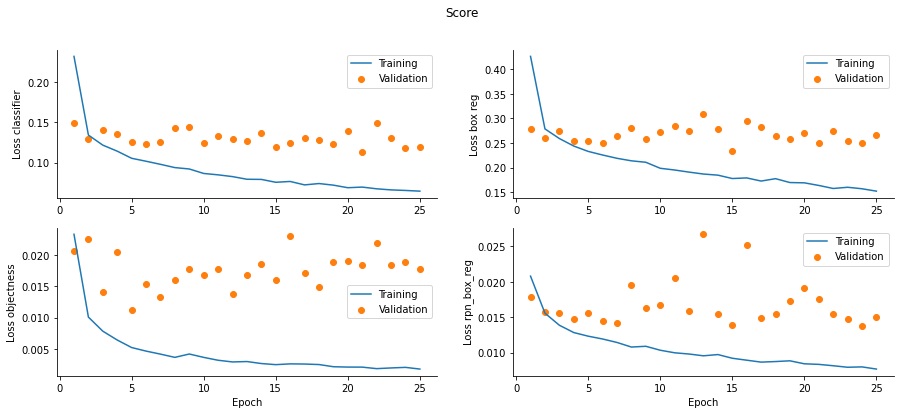

In [56]:
train_score = perf1.train_score
val_score = perf1.validation_score

# Mean for epoch of training score
sizepoch = perf1.iterperepoch-1
epochscore1 = []
sum = 0
for i in range(len(train_score[0])):
  sum += train_score[0][i]
  if ((i+1) % sizepoch) == 0:
    epochscore1.append(sum/sizepoch)
    sum = 0
epochscore2 = []
sum = 0
for i in range(len(train_score[0])):
  sum += train_score[1][i]
  if ((i+1) % sizepoch) == 0:
    epochscore2.append(sum/sizepoch)
    sum = 0
epochscore3 = []
sum = 0
for i in range(len(train_score[0])):
  sum += train_score[2][i]
  if ((i+1) % sizepoch) == 0:
    epochscore3.append(sum/sizepoch)
    sum = 0
epochscore4 = []
sum = 0
for i in range(len(train_score[0])):
  sum += train_score[3][i]
  if ((i+1) % sizepoch) == 0:
    epochscore4.append(sum/sizepoch)
    sum = 0

# Mean for epoch of validation score
sizepoch = perf1.iterperepochval
epochvalscore1 = []
sum = 0
for i in range(len(val_score[0])):
  sum += val_score[0][i]
  if ((i+1) % sizepoch) == 0:
    epochvalscore1.append(sum/sizepoch)
    sum = 0
epochvalscore2 = []
sum = 0
for i in range(len(val_score[0])):
  sum += val_score[1][i]
  if ((i+1) % sizepoch) == 0:
    epochvalscore2.append(sum/sizepoch)
    sum = 0
epochvalscore3 = []
sum = 0
for i in range(len(val_score[0])):
  sum += val_score[2][i]
  if ((i+1) % sizepoch) == 0:
    epochvalscore3.append(sum/sizepoch)
    sum = 0
epochvalscore4 = []
sum = 0
for i in range(len(val_score[0])):
  sum += val_score[3][i]
  if ((i+1) % sizepoch) == 0:
    epochvalscore4.append(sum/sizepoch)
    sum = 0

print(len(epochscore1))

fig, axs = plt.subplots(nrows=2,ncols=2, figsize=(15, 6))
# fig, axs = plt.subplots(nrows=2,ncols=3, sharex=True, sharey=True)
fig.suptitle('Score')
# fig.tight_layout()
# peut-être mieux: plt.subplots_adjust

X = range(len(epochscore1)) + np.ones(len(epochscore1))
Xval = range(len(epochvalscore1))+ np.ones(len(epochscore1))

axs[0,0].plot(X, epochscore1, label="Training")
axs[0,0].scatter(Xval, epochvalscore1, color='C1', label="Validation")
#axs[0,0].set_title('Sample 1')
axs[0,0].set_ylabel('Loss classifier')
# axs[0,0].set_xlabel('x1')
axs[0,0].legend()

axs[0,1].plot(X, epochscore2, label="Training")
axs[0,1].scatter(Xval, epochvalscore2, color='C1', label="Validation")
#axs[0,1].set_title('Sample 2')
axs[0,1].set_ylabel('Loss box reg')
axs[0,1].legend()
#axs[0,1].set_xlabel('x2')

# axs[1,0].scatter(X, train_score[2], color = "blue", edgecolors = "white", linewidths = 0.1, s=20, alpha = 0.7)
axs[1,0].plot(X, epochscore3, label="Training")
axs[1,0].scatter(Xval, epochvalscore3, color='C1', label="Validation")
#axs[1,0].set_title('Sample 3')
axs[1,0].set_ylabel('Loss objectness')
axs[1,0].set_xlabel('Epoch')
axs[1,0].legend()

axs[1,1].plot(X, epochscore4, label="Training")
axs[1,1].scatter(Xval, epochvalscore4, color='C1', label="Validation")
#axs[1,1].set_title('Sample 4')
axs[1,1].set_ylabel('Loss rpn_box_reg')
axs[1,1].set_xlabel('Epoch')
axs[1,1].legend()

for subg in axs.flat: # Apply settings on all subgraphs
    subg.set_facecolor('white') # remove grey background

    subg.spines['right'].set_visible(False) # Hide the right and top spines
    subg.spines['top'].set_visible(False) 
    subg.yaxis.set_ticks_position('left') # only show left and bottom axis
    subg.xaxis.set_ticks_position('bottom')

plt.rcParams["figure.figsize"] = (40,20) # remove to see overlapping subplots
# plt.savefig("/content/drive/MyDrive/Github/BirdDetection-FeaturesExtraction/images/performance/score.png")
plt.show()